# Using Pre-Trained SamSiam Model for Fetal Saturation Estimation!
THe ultimate test for the SamSiam model will be testing if the encodings it produce are good at saturation estimation. The SamSiam model itself does its' job decently. Making encodings that are depth independent. But it only maxmizes similarity, not the dissimilarity between different saturation points.

## Method
Take Intensity from the simulation dataset and pass it through the SamSiam to produce depth independent encodings. Repeat this step for both $I_1$ and $I_2$. From there on, either
1. Create EPR using $I_1$ and $I_2$, then use EPR to estimate fetal saturation (Makes more theoretical sense)
2. Use $I_1$ and $I_2$ directly to estimate fetal saturation (Easier to Code)
For both cases, make sure the same depth points remain as validation as the SamSiam training. 

## Issues
1. SamSiam Transformation makes all inputs the same!

## Step 1 : Load Data

In [1]:
from pathlib import Path
import json
import pandas as pd

file_name = 'I1_and_I2'
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = DATA_PATH.with_suffix(".json")
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]
print(features) # [I1 | I2]

['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1', '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1', '55_2.0_1', '59_2.0_1', '64_2.0_1', '68_2.0_1', '72_2.0_1', '77_2.0_1', '81_2.0_1', '86_2.0_1', '90_2.0_1', '94_2.0_1', '10_1.0_1', '15_1.0_1', '19_1.0_1', '24_1.0_1', '28_1.0_1', '33_1.0_1', '37_1.0_1', '41_1.0_1', '46_1.0_1', '50_1.0_1', '55_1.0_1', '59_1.0_1', '64_1.0_1', '68_1.0_1', '72_1.0_1', '77_1.0_1', '81_1.0_1', '86_1.0_1', '90_1.0_1', '94_1.0_1', '10_2.0_2', '15_2.0_2', '19_2.0_2', '24_2.0_2', '28_2.0_2', '33_2.0_2', '37_2.0_2', '41_2.0_2', '46_2.0_2', '50_2.0_2', '55_2.0_2', '59_2.0_2', '64_2.0_2', '68_2.0_2', '72_2.0_2', '77_2.0_2', '81_2.0_2', '86_2.0_2', '90_2.0_2', '94_2.0_2', '10_1.0_2', '15_1.0_2', '19_1.0_2', '24_1.0_2', '28_1.0_2', '33_1.0_2', '37_1.0_2', '41_1.0_2', '46_1.0_2', '50_1.0_2', '55_1.0_2', '59_1.0_2', '64_1.0_2', '68_1.0_2', '72_1.0_2', '77_1.0_2', '81_1.0_2', '86_1.0_2', '90_1.0_2', '94_1.0_2']


# Step 2 : Load SamSiam & Transform Data

In [2]:
import os
import torch
from inverse_modelling_tfo.model_training.custom_models import CustomSiam

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

MODEL_PATH = Path().resolve().parent.parent / "models" / "siam_model.pth"
model_init_parms = {'encoder_nodes': [40, 30, 20, 20]}
model = CustomSiam(**model_init_parms)
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
print(model)    # Check the model

CustomSiam(
  (encoder): PerceptronBD(
    (model): Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=30, out_features=20, bias=True)
      (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=20, bias=True)
      (7): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (projector): PerceptronBD(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=10, out_features=20, bias=True)
      (4): Flatten(start_dim=1, en

# Step 3 : Transform Data using SamSiam

In [3]:
import joblib
model = model.eval().cpu()  # Should be faster to run on CPU -> xfrm data(on cpu) -> then move to GPU
x_scaler = joblib.load(Path().resolve().parent.parent / "models" / "siam_xscaler")

temp_features = data[features].values
half_len = len(features)//2
i1 = torch.tensor(x_scaler.transform(temp_features[:, :half_len]), dtype=torch.float32)
i2 = torch.tensor(x_scaler.transform(temp_features[:, half_len:]), dtype=torch.float32)

new_features_i1 = model.projector(model.encoder(i1))
new_features_i2= model.projector(model.encoder(i2))

new_feature_names = [f'X{i}' for i in range(new_features_i1.shape[1] * 2)]
data[new_feature_names] = pd.DataFrame(torch.cat([new_features_i1, new_features_i2], dim=1).detach().numpy())

/home/rraiyan/cybercat/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/rraiyan/cybercat/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Step 3.5: DataViz

In [4]:
data[new_feature_names].describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
count,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,...,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000
mean,0.018869,0.031018,-0.001097,-0.033863,-0.034789,-0.026678,-0.041878,-0.031753,-0.043229,-0.042450,...,-0.028312,-0.015650,-0.035024,0.034795,-0.031465,-0.042770,-0.022957,0.061675,-0.032625,-0.027886
std,0.579711,0.420052,0.529027,0.674639,0.473709,0.535980,0.504272,0.534405,0.557894,0.474260,...,0.512670,0.522798,0.510369,0.674564,0.501989,0.477221,0.523131,0.665704,0.538971,0.566583
min,-1.246003,-0.281259,-0.486755,-1.389381,-0.785057,-0.545409,-0.889948,-0.971461,-0.909448,-0.816426,...,-0.892052,-0.380759,-0.597166,-0.641791,-0.577970,-0.671470,-0.413142,-1.054178,-0.581737,-0.623872
25%,-0.319880,-0.236493,-0.273588,-0.831021,-0.234831,-0.172604,-0.298629,-0.247999,-0.288132,-0.363527,...,-0.155654,-0.185023,-0.226043,-0.264897,-0.188080,-0.255807,-0.155086,-0.158573,-0.200068,-0.260886
50%,-0.314782,-0.224885,-0.261094,0.316246,-0.200700,-0.133058,0.008907,-0.219575,-0.004107,0.033541,...,-0.143686,-0.104036,-0.192773,-0.253831,-0.140166,-0.233598,-0.112420,-0.117631,-0.147101,-0.234739
75%,0.186732,0.185131,0.078409,0.332832,-0.181002,-0.122340,0.028029,-0.205099,0.014121,0.052709,...,-0.127293,-0.086933,-0.180282,0.058455,-0.133383,-0.171559,-0.103294,0.154751,-0.142329,-0.223444
max,3.482158,3.429418,3.973306,2.356043,1.454552,3.632542,3.835344,2.478532,3.705791,3.615677,...,3.916825,4.480936,2.988652,6.527444,3.335549,1.900735,3.743752,5.301756,3.609872,3.697293


# Step 4 : Train The Model

In [11]:
from model_trainer import ModelTrainer, HoldOneOut, TorchLossWrapper, DataLoaderGenerator
from model_trainer.custom_models import PerceptronBD
from torch.optim.adam import Adam
from torch.nn import MSELoss
from sklearn.preprocessing import StandardScaler


y_column = ["Fetal Saturation"]
y_scaler = StandardScaler()
data[y_column] = y_scaler.fit_transform(data[y_column])

IN_FEATURES = len(new_feature_names)    # 80
OUT_FEATURES = 1

sat_model = PerceptronBD([IN_FEATURES, 40, 20, OUT_FEATURES])

all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut("Maternal Wall Thickness", all_depths[5:10])

criterion = TorchLossWrapper(MSELoss(), name="fetal_sat")

dataloader_gen = DataLoaderGenerator(data, new_feature_names, y_column, 32, {"shuffle": True})

trainer = ModelTrainer(sat_model, dataloader_gen, validation_method, criterion)

In [12]:
trainer.set_optimizer(Adam, {'lr': 1e-2, 'weight_decay': 1e-4})
trainer.run(10)

                   Losses                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃    👀     ┃ Train Loss ┃ Validation Loss ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fetal_sat │   0.9858   │     1.0005      │
└───────────┴────────────┴─────────────────┘

<console width=115 ColorSystem.TRUECOLOR>

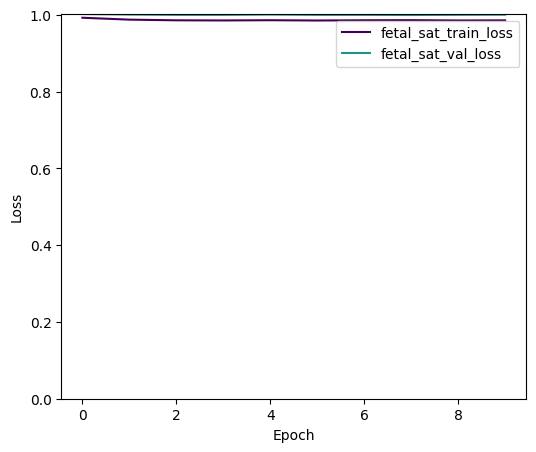

In [13]:
loss_plot = criterion.plot_losses()
criterion.print_table()